开始准备Flowers102数据集...
正在下载: flowers102_data/102flowers.tgz


flowers102_data/102flowers.tgz: 100%|██████████| 329M/329M [01:38<00:00, 3.50MiB/s] 


正在下载: flowers102_data/imagelabels.mat


flowers102_data/imagelabels.mat: 100%|██████████| 502/502 [00:00<00:00, 1.79MiB/s]


正在下载: flowers102_data/setid.mat


flowers102_data/setid.mat: 100%|██████████| 14.6k/14.6k [00:00<00:00, 12.8MiB/s]


所有文件下载完成！
正在解压图片文件...
解压完成！
正在整理数据集结构...


整理测试集: 100%|██████████| 6149/6149 [00:00<00:00, 17143.22it/s]


数据集整理完成！
训练集: 1020 张图片
验证集: 1020 张图片
测试集: 6149 张图片
train集: 1020 张图片
val集: 1020 张图片
test集: 6149 张图片

可视化训练集样本:


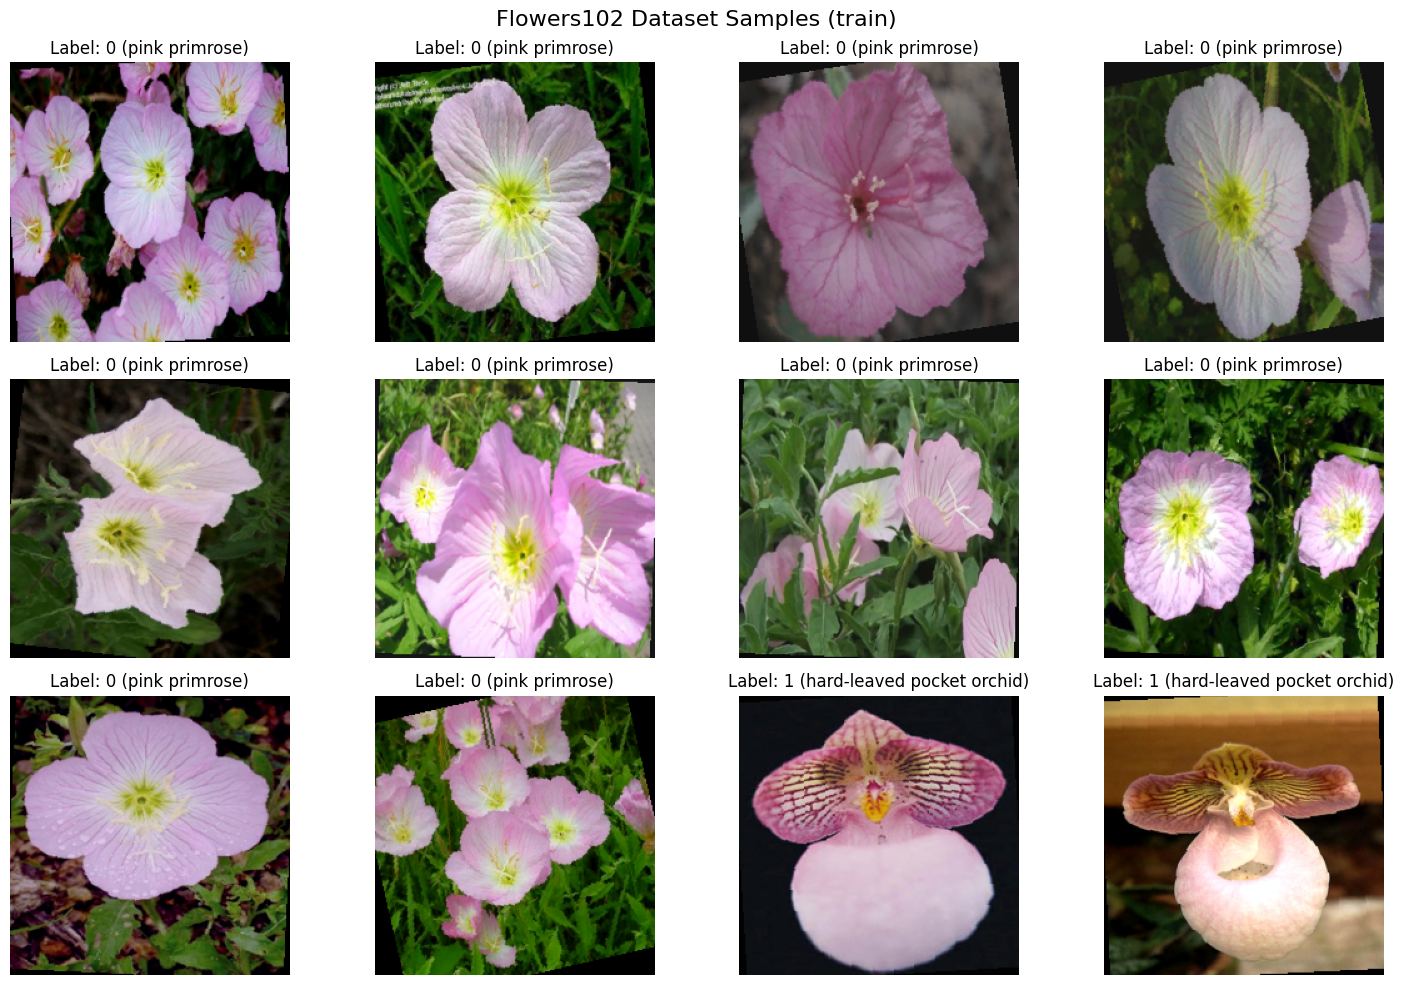


显示类别分布:


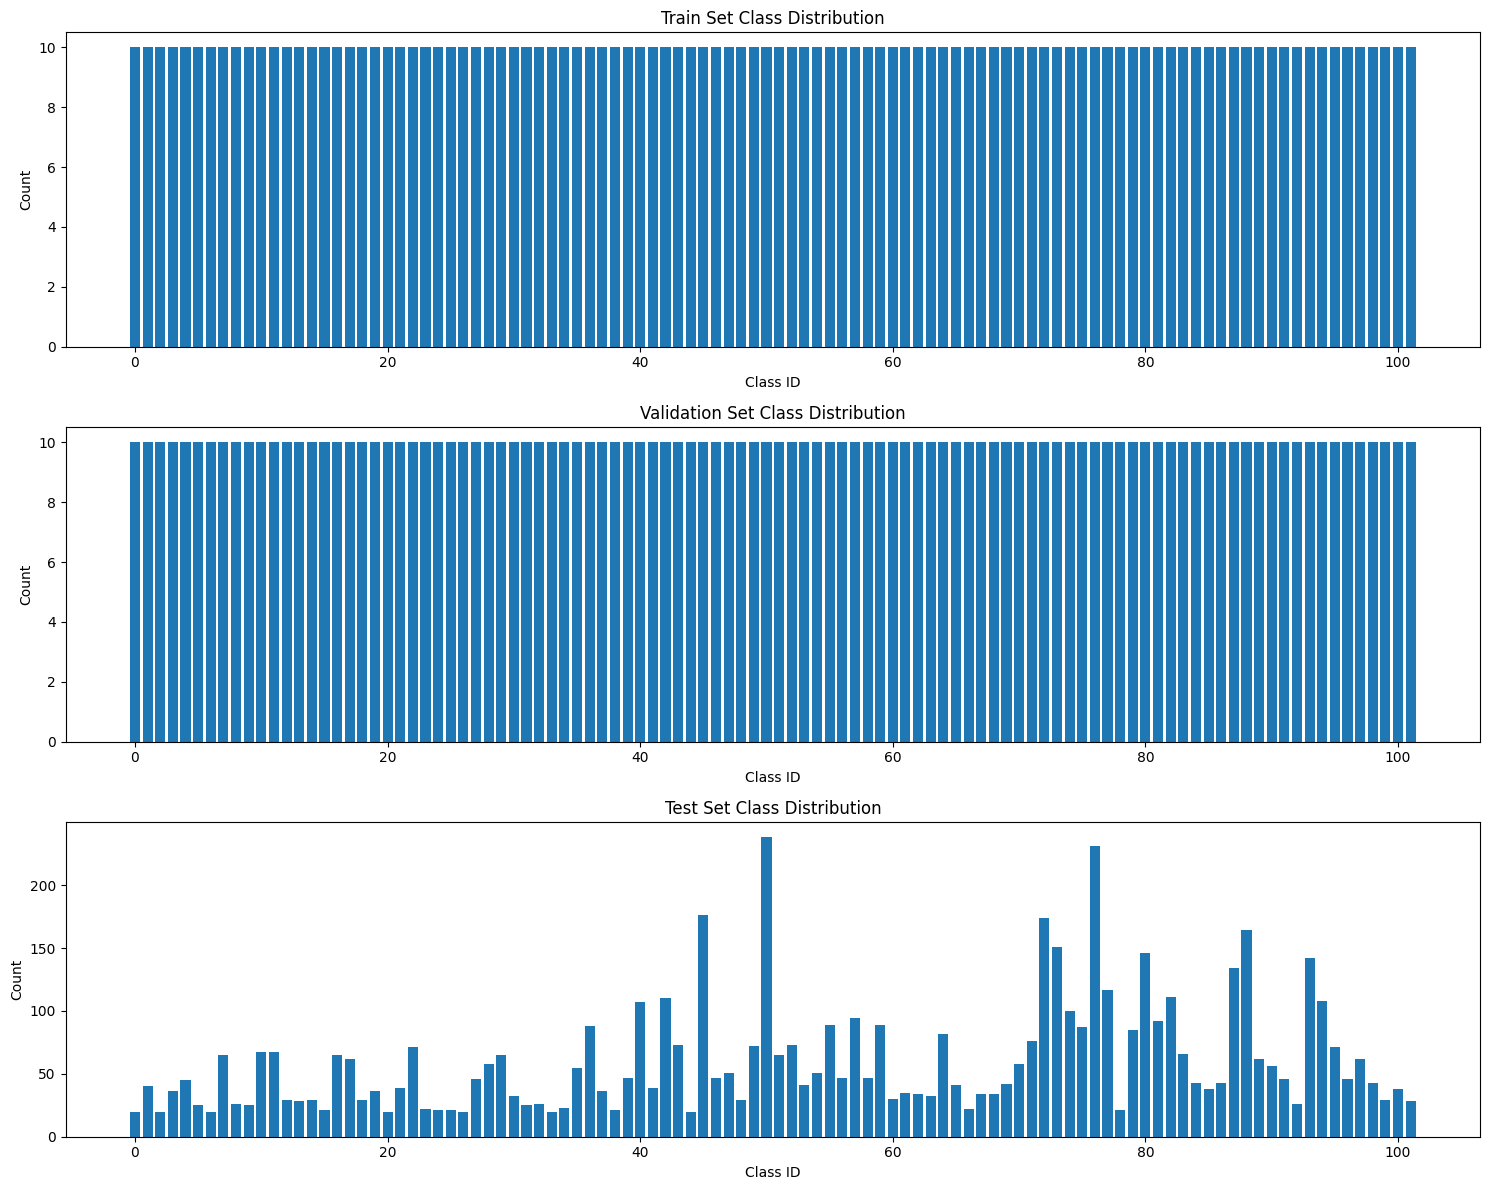


数据集信息:
训练集大小: 1020
验证集大小: 1020
测试集大小: 6149
总类别数: 102

批次形状: torch.Size([16, 3, 224, 224])
标签: tensor([23, 27, 89, 41, 34, 12, 99, 91, 69, 37])


In [8]:
# flowers102_download_preprocess.ipynb
import os
import torch
import numpy as np
import tarfile
import requests
import shutil
from tqdm import tqdm
from PIL import Image
import json
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

# ===================== 配置 =====================
DATA_DIR = "flowers102_data"
DOWNLOAD_URL = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
LABELS_URL = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"
SPLITS_URL = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat"

CLASS_NAMES = [
    "pink primrose", "hard-leaved pocket orchid", "canterbury bells", "sweet pea",
    "english marigold", "tiger lily", "moon orchid", "bird of paradise",
    "monkshood", "globe thistle", "snapdragon", "colt's foot",
    "king protea", "spear thistle", "yellow iris", "globe-flower",
    "purple coneflower", "peruvian lily", "balloon flower", "giant white arum lily",
    "fire lily", "pincushion flower", "fritillary", "red ginger",
    "grape hyacinth", "corn poppy", "prince of wales feathers", "stemless gentian",
    "artichoke", "sweet william", "carnation", "garden phlox",
    "love in the mist", "mexican aster", "alpine sea holly", "ruby-lipped cattleya",
    "cape flower", "great masterwort", "siam tulip", "lenten rose",
    "barbeton daisy", "daffodil", "sword lily", "poinsettia",
    "bolero deep blue", "wallflower", "marigold", "buttercup",
    "oxeye daisy", "common dandelion", "petunia", "wild pansy",
    "primula", "sunflower", "pelargonium", "bishop of llandaff",
    "gaura", "geranium", "orange dahlia", "pink-yellow dahlia",
    "cautleya spicata", "japanese anemone", "black-eyed susan", "silverbush",
    "californian poppy", "osteospermum", "spring crocus", "bearded iris",
    "windflower", "tree poppy", "gazania", "azalea",
    "water lily", "rose", "thorn apple", "morning glory",
    "passion flower", "lotus", "toad lily", "anthurium",
    "frangipani", "clematis", "hibiscus", "columbine",
    "desert-rose", "tree mallow", "magnolia", "cyclamen",
    "watercress", "canna lily", "hippeastrum", "bee balm",
    "ball moss", "foxglove", "bougainvillea", "camellia",
    "mallow", "mexican petunia", "bromelia", "blanket flower",
    "trumpet creeper", "blackberry lily"
]

# ===================== 下载函数 =====================
def download_file(url, filename):
    """下载文件并显示进度条"""
    print(f"正在下载: {filename}")

    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))

    with open(filename, 'wb') as file, tqdm(
        desc=filename,
        total=total_size,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(chunk_size=1024):
            size = file.write(data)
            bar.update(size)

def download_flowers102():
    """下载Flowers102数据集"""
    os.makedirs(DATA_DIR, exist_ok=True)

    # 下载主文件
    tgz_path = os.path.join(DATA_DIR, "102flowers.tgz")
    if not os.path.exists(tgz_path):
        download_file(DOWNLOAD_URL, tgz_path)

    # 下载标签文件
    labels_path = os.path.join(DATA_DIR, "imagelabels.mat")
    if not os.path.exists(labels_path):
        download_file(LABELS_URL, labels_path)

    # 下载划分文件
    splits_path = os.path.join(DATA_DIR, "setid.mat")
    if not os.path.exists(splits_path):
        download_file(SPLITS_URL, splits_path)

    print("所有文件下载完成！")

# ===================== 解压和预处理 =====================
def extract_and_organize():
    """解压并整理数据集"""
    tgz_path = os.path.join(DATA_DIR, "102flowers.tgz")
    images_dir = os.path.join(DATA_DIR, "jpg")

    # 解压文件
    if not os.path.exists(images_dir):
        print("正在解压图片文件...")
        with tarfile.open(tgz_path, 'r:gz') as tar:
            tar.extractall(DATA_DIR)
        print("解压完成！")

    # 使用scipy加载.mat文件
    try:
        import scipy.io as sio

        # 加载标签
        labels_mat = sio.loadmat(os.path.join(DATA_DIR, "imagelabels.mat"))
        labels = labels_mat['labels'][0] - 1  # 转换为0-based索引

        # 加载划分
        splits_mat = sio.loadmat(os.path.join(DATA_DIR, "setid.mat"))
        train_ids = splits_mat['trnid'][0]
        val_ids = splits_mat['valid'][0]
        test_ids = splits_mat['tstid'][0]

        return images_dir, labels, train_ids, val_ids, test_ids

    except ImportError:
        print("需要scipy库来读取.mat文件，请先安装: pip install scipy")
        return None

def create_torchvision_structure():
    """创建torchvision需要的目录结构（train/test/val）"""
    images_dir, labels, train_ids, val_ids, test_ids = extract_and_organize()

    # 创建目录
    train_dir = os.path.join(DATA_DIR, "train")
    val_dir = os.path.join(DATA_DIR, "val")
    test_dir = os.path.join(DATA_DIR, "test")

    for dir_path in [train_dir, val_dir, test_dir]:
        os.makedirs(dir_path, exist_ok=True)
        # 为每个类别创建子目录
        for class_idx in range(102):
            class_dir = os.path.join(dir_path, str(class_idx))
            os.makedirs(class_dir, exist_ok=True)

    # 复制图片到相应目录
    print("正在整理数据集结构...")

    # 训练集
    for img_id in tqdm(train_ids, desc="整理训练集"):
        img_name = f"image_{img_id:05d}.jpg"
        src_path = os.path.join(images_dir, img_name)
        class_idx = labels[img_id - 1]  # 图片ID是1-based
        dst_dir = os.path.join(train_dir, str(class_idx))
        shutil.copy(src_path, dst_dir)

    # 验证集
    for img_id in tqdm(val_ids, desc="整理验证集"):
        img_name = f"image_{img_id:05d}.jpg"
        src_path = os.path.join(images_dir, img_name)
        class_idx = labels[img_id - 1]
        dst_dir = os.path.join(val_dir, str(class_idx))
        shutil.copy(src_path, dst_dir)

    # 测试集
    for img_id in tqdm(test_ids, desc="整理测试集"):
        img_name = f"image_{img_id:05d}.jpg"
        src_path = os.path.join(images_dir, img_name)
        class_idx = labels[img_id - 1]
        dst_dir = os.path.join(test_dir, str(class_idx))
        shutil.copy(src_path, dst_dir)

    print(f"数据集整理完成！")
    print(f"训练集: {len(train_ids)} 张图片")
    print(f"验证集: {len(val_ids)} 张图片")
    print(f"测试集: {len(test_ids)} 张图片")

    return train_dir, val_dir, test_dir

# ===================== PyTorch Dataset类 =====================
class Flowers102Dataset(Dataset):
    """自定义Flowers102数据集类"""
    def __init__(self, root_dir, transform=None, split='train'):
        """
        Args:
            root_dir: 数据根目录
            transform: 数据增强变换
            split: 'train', 'val', 或 'test'
        """
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.split = split

        # 收集所有图片路径和标签
        self.image_paths = []
        self.labels = []

        for class_idx in range(102):  # 102个类别
            class_dir = os.path.join(self.root_dir, str(class_idx))
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.endswith('.jpg'):
                        self.image_paths.append(os.path.join(class_dir, img_name))
                        self.labels.append(class_idx)

        print(f"{split}集: {len(self.image_paths)} 张图片")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# ===================== 快速使用函数 =====================
def prepare_flowers102():
    """一键准备Flowers102数据集"""
    print("开始准备Flowers102数据集...")

    # 1. 下载
    download_flowers102()

    # 2. 解压和整理
    train_dir, val_dir, test_dir = create_torchvision_structure()

    return train_dir, val_dir, test_dir

def get_flowers102_dataloaders(batch_size=32, image_size=(224, 224)):
    """获取Flowers102数据加载器"""
    # 数据增强
    train_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # 创建数据集
    train_dataset = Flowers102Dataset(DATA_DIR, transform=train_transform, split='train')
    val_dataset = Flowers102Dataset(DATA_DIR, transform=test_transform, split='val')
    test_dataset = Flowers102Dataset(DATA_DIR, transform=test_transform, split='test')

    # 创建数据加载器
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset

# ===================== 可视化 =====================
def visualize_dataset(dataset, num_samples=12):
    """可视化数据集样本"""
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    axes = axes.ravel()

    for i in range(num_samples):
        img, label = dataset[i]
        # 反归一化
        img = img.numpy().transpose(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label} ({CLASS_NAMES[label]})")
        axes[i].axis('off')

    plt.suptitle(f"Flowers102 Dataset Samples ({dataset.split})", fontsize=16)
    plt.tight_layout()
    plt.show()

def show_class_distribution(train_dataset, val_dataset, test_dataset):
    """显示类别分布"""
    def count_classes(dataset):
        counts = [0] * 102
        for _, label in dataset:
            counts[label] += 1
        return counts

    train_counts = count_classes(train_dataset)
    val_counts = count_classes(val_dataset)
    test_counts = count_classes(test_dataset)

    fig, axes = plt.subplots(3, 1, figsize=(15, 12))

    axes[0].bar(range(102), train_counts)
    axes[0].set_title('Train Set Class Distribution')
    axes[0].set_xlabel('Class ID')
    axes[0].set_ylabel('Count')

    axes[1].bar(range(102), val_counts)
    axes[1].set_title('Validation Set Class Distribution')
    axes[1].set_xlabel('Class ID')
    axes[1].set_ylabel('Count')

    axes[2].bar(range(102), test_counts)
    axes[2].set_title('Test Set Class Distribution')
    axes[2].set_xlabel('Class ID')
    axes[2].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

# ===================== 主程序 =====================
if __name__ == "__main__":
    # 一键准备数据集
    train_dir, val_dir, test_dir = prepare_flowers102()

    # 获取数据加载器
    train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = get_flowers102_dataloaders(batch_size=16)

    # 可视化
    print("\n可视化训练集样本:")
    visualize_dataset(train_dataset)

    print("\n显示类别分布:")
    show_class_distribution(train_dataset, val_dataset, test_dataset)

    print("\n数据集信息:")
    print(f"训练集大小: {len(train_dataset)}")
    print(f"验证集大小: {len(val_dataset)}")
    print(f"测试集大小: {len(test_dataset)}")
    print(f"总类别数: 102")

    # 测试一个批次
    for images, labels in train_loader:
        print(f"\n批次形状: {images.shape}")
        print(f"标签: {labels[:10]}")
        break